# Analyse d'image et Traitement en Python

Bienvenue dans ce notebook dédié à l'analyse d'image et au traitement, créé par Mouafak Dakhlaoui, étudiant en IIA4. Dans ce projet, nous explorerons différentes étapes pour extraire des caractéristiques d'une photo contenant divers objets tels qu'une orange, un bouchon, du fromage "fraidoux", et une planche.

## Objectif du Projet

L'objectif de ce mini-projet est d'utiliser un appareil photo numérique pour capturer une image en couleurs vraies, comportant des objets de tailles, formes et couleurs différentes. Ensuite, nous effectuerons des traitements sur cette image, notamment la conversion en niveaux de gris, la binarisation, la détection de contours, et enfin, l'étiquetage des objets détectés.

## Description de la Scène Capturée

La scène capturée inclut une orange, un bouchon, du fromage "fraidoux", et une planche. Ces objets présentent une diversité de couleurs, formes, et tailles, offrant ainsi un ensemble varié pour notre analyse.

<img src="./images/kitchen_objects.jpg" alt="drawing" width="300"/>

## Matériel Utilisé

Nous avons choisi d'utiliser un appareil photo numérique, en l'occurrence celui par défaut de notre téléphone Infinix Note 11 Pro. Voici les spécifications de la caméra :

| Caractéristique       | Valeur                                                         |
| --------------------- | -------------------------------------------------------------- |
| Caméra Arrière        | 64 MP (grand-angle) + 13 MP (téléobjectif) + 2 MP (profondeur) |
| Résolution de l'image | 1440p                                                          |
| Enregistrement Vidéo  | Oui                                                            |
| Flash                 | Quad-LED, HDR, panorama                                        |

## Informations Techniques

Jetons un coup d'œil aux détails techniques de l'image à l'aide du code ci-dessous. Nous allons afficher la hauteur, la largeur et le nombre total de pixels dans l'image.


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import scipy


image = cv2.imread("./images/kitchen_objects.jpg")
height, width = image.shape[:2]
n_pixels = height * width

print(f"Hauteur: {height}")
print(f"Largeur: {width}")
print(f"Number de pixels: {n_pixels}")

Hauteur: 4608
Largeur: 3456
Number de pixels: 15925248


## Affichage de l'Histograme de Couleur

Après avoir obtenu les informations sur l'image capturée avec les spécifications de la caméra Infinix Note 11 Pro, explorons davantage en affichant l'histogramme de couleur pour chaque canal. Cela nous permettra de comprendre la distribution des couleurs dans l'image.

### Détails de l'Image

-   **Hauteur:** 4608 pixels
-   **Largeur:** 3456 pixels
-   **Nombre de Pixels:** 15,925,248


### Affichage de l'Histograme de Couleur


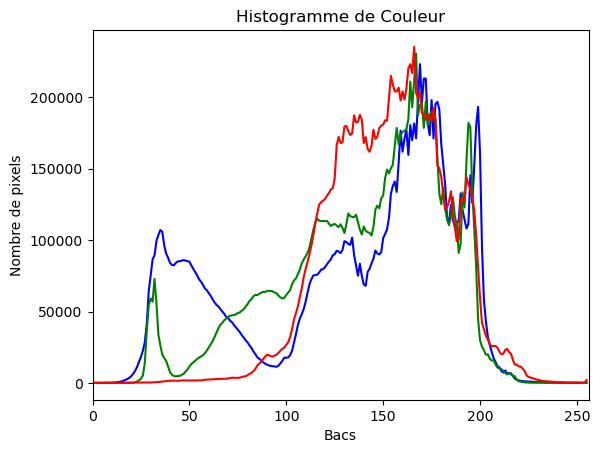

In [2]:
chans = cv2.split(image)
colors = ("b", "g", "r")
plt.figure()
plt.title("Histogramme de Couleur")
plt.xlabel("Bacs")
plt.ylabel("Nombre de pixels")
for chan, color in zip(chans, colors):
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    plt.plot(hist, color=color)
    plt.xlim([0, 256])
plt.show()

## Après l'Affichage des Histogrammes

Après avoir tracé les histogrammes, nous pouvons clairement voir une distribution bimodale dans l'histogramme du canal bleu. Nous pouvons également observer cela légèrement dans le canal vert, mais le canal rouge semble avoir une distribution normale, ce qui implique qu'il offre moins d'aide pour la détection d'objets car il ne contribue pas beaucoup à différencier le premier plan du fond. Pour vérifier cela, nous pouvons afficher chacun des 3 canaux de l'image.

### Affichage des Canaux de Couleur

Nous allons visualiser chaque canal de couleur de l'image individuellement :

1. **Canal Bleu :** Affiche une version de l'image avec seulement le canal bleu.

2. **Canal Vert :** Affiche une version de l'image avec seulement le canal vert.

3. **Canal Rouge :** Affiche une version de l'image avec seulement le canal rouge.

Cela nous permettra de confirmer visuellement la distribution des couleurs que nous avons observée dans les histogrammes.


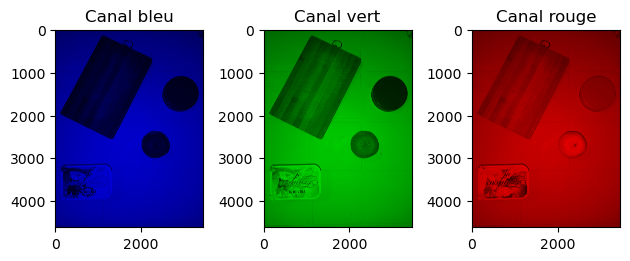

In [3]:
def show_image_channels(image):
    blue_image = np.zeros(image.shape, dtype="uint8")
    blue_image[:, :, 2] = image[:, :, 0]
    green_image = np.zeros(image.shape, dtype="uint8")
    green_image[:, :, 1] = image[:, :, 1]
    red_image = np.zeros(image.shape, dtype="uint8")
    red_image[:, :, 0] = image[:, :, 2]

    _, ax = plt.subplots(1, 3)
    ax[0].imshow(blue_image)
    ax[0].set_title("Canal bleu")
    ax[1].imshow(green_image)
    ax[1].set_title("Canal vert")
    ax[2].imshow(red_image)
    ax[2].set_title("Canal rouge")
    plt.tight_layout()


show_image_channels(image)

## Après la Visualisation de Chacun des Canaux

Après avoir visualisé chaque canal, nous pouvons clairement voir que les pixels du premier plan et du fond ont des valeurs rouges similaires. Nous pouvons mieux différencier les pixels du premier plan et du fond pour les canaux bleu et vert. Le "fraidoux" semble être le plus difficile à détecter car il a des couleurs claires (similaires à l'arrière-plan dans ce cas).

### Observation Visuelle des Canaux

Nous pouvons tirer les observations suivantes en examinant visuellement chacun des canaux de couleur de l'image :

-   **Canal Bleu :** Les pixels du premier plan et du fond ont des valeurs bleues distinctes, facilitant la différenciation.

-   **Canal Vert :** De manière similaire au canal bleu, les valeurs vertes des pixels du premier plan et du fond sont bien différenciées.

-   **Canal Rouge :** Les valeurs rouges sont similaires pour le premier plan et le fond, ce qui complique la distinction entre eux.

En raison de ces observations, nous pouvons envisager des approches spécifiques pour améliorer la détection des objets, en particulier du "fraidoux" qui présente des défis en raison de ses couleurs claires.


## Transformation en Niveaux de Gris

Nous allons maintenant appliquer une transformation linéaire à l'image RGB pour la convertir en une image en niveaux de gris. Deux approches seront proposées : la première utilise une moyenne pondérée des canaux de couleur, tandis que la seconde repose sur l'algorithme PCA (Analyse en Composantes Principales).

### Approche 1 : Moyenne Pondérée selon la Perception Humaine

La première approche consiste à utiliser une moyenne pondérée des canaux de couleur (rouge, vert et bleu), où chaque canal est pondéré selon la sensibilité de l'œil humain. Les coefficients de pondération sont choisis comme suit :

-   Coefficient Rouge (R) : 0.299
-   Coefficient Vert (G) : 0.587
-   Coefficient Bleu (B) : 0.114

Cette pondération est basée sur la sensibilité relative de l'œil humain aux différentes couleurs.

### Approche 2 : Algorithme PCA

La deuxième approche repose sur l'algorithme PCA, qui applique une transformation linéaire tout en réduisant la dimensionnalité de l'image. L'idée est de maximiser la variance, ce qui se traduit dans le traitement d'image par une maximisation du contraste. Cette maximisation du contraste peut être bénéfique pour la détection de contours.

Ces deux approches seront implémentées et comparées afin de déterminer laquelle offre une meilleure représentation en niveaux de gris, en particulier en ce qui concerne la maximisation du contraste, ce qui peut être crucial pour nos futures étapes de détection de contours.


In [4]:
# Approche 1: Moyenne Pondérée selon le Perception Humaine
coeff_r = 0.299
coeff_g = 0.587
coeff_b = 0.114
grayscale_image = (
    coeff_r * image[..., 0] + coeff_g * image[..., 1] + coeff_b * image[..., 2]
)
grayscale_image = grayscale_image.astype(np.uint8)

In [5]:
# Approche 2: Algorithme PCA
pca = PCA(n_components=1)
pca.fit(image.reshape(n_pixels, 3))
pca_image = pca.transform(image.reshape(n_pixels, 3))
pca_image = pca_image.reshape(height, width)
pca_image = (
    (pca_image - pca_image.min()) / (pca_image.max() - pca_image.min()) * 255
).astype(np.uint8)
pca_image = 255 - pca_image

## Visualisation des Images en Niveaux de Gris et de Leurs Histogrammes

Après avoir appliqué les deux approches pour convertir l'image en niveaux de gris, visualisons les images résultantes ainsi que leurs histogrammes respectifs.


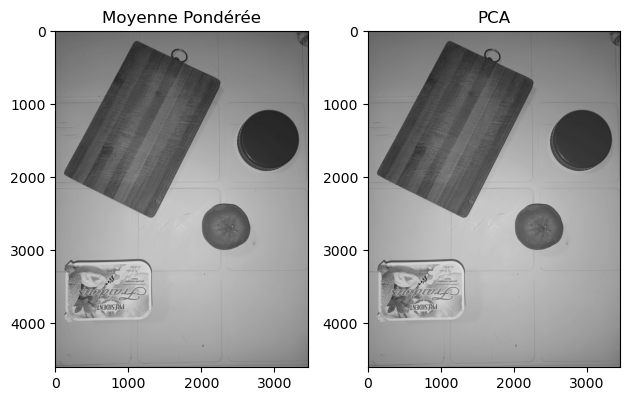

In [6]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(grayscale_image, cmap="gray")
axes[0].set_title("Moyenne Pondérée")
axes[1].imshow(pca_image, cmap="gray")
axes[1].set_title("PCA")
plt.tight_layout()

## Analyse des Histogrammes pour Discerner les Différences

Bien que les deux images en niveaux de gris puissent sembler similaires visuellement, examinons de plus près leurs histogrammes respectifs pour discerner d'éventuelles différences significatives.


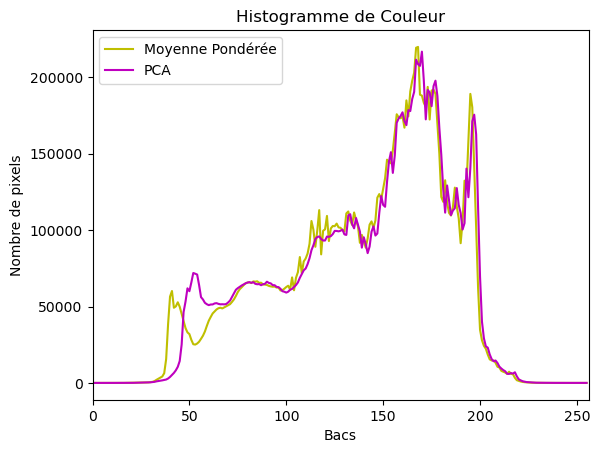

In [7]:
colors = ("y", "m")

plt.figure()
plt.title("Histogramme de Couleur")
plt.xlabel("Bacs")
plt.ylabel("Nombre de pixels")
for i, g_image in enumerate((grayscale_image, pca_image)):
    hist = cv2.calcHist([g_image], [0], None, [256], [0, 256])
    plt.plot(hist, color=colors[i])
    plt.xlim([0, 256])
plt.legend(["Moyenne Pondérée", "PCA"])
plt.show()

## Choix de l'Approche PCA pour la Transformation en Niveaux de Gris

Bien que visuellement les deux images en niveaux de gris et leurs histogrammes semblent très similaires, nous prenons la décision de continuer avec l'approche utilisant l'algorithme PCA pour la transformation en niveaux de gris.

### Raisons du Choix

-   **Maximisation de la Variance :** L'algorithme PCA a été choisi pour sa capacité à maximiser la variance, ce qui se traduit par une maximisation du contraste dans l'image. Cela peut être particulièrement bénéfique pour la détection de contours.

-   **Flexibilité :** L'approche PCA offre une flexibilité pour gérer différentes distributions de couleurs, ce qui peut être crucial dans des scénarios complexes.

Nous poursuivrons donc avec l'image obtenue à l'aide de l'algorithme PCA pour les étapes suivantes de notre analyse d'image.


## Binarisation de l'Image PCA avec Seuil et Inversion du Masque

Dans le processus de binarisation de l'image en niveaux de gris obtenue avec l'algorithme PCA, nous allons introduire une inversion du masque binaire dès le début. Cependant, il est important de noter que cette approche peut ne pas fonctionner de manière optimale en raison des caractéristiques spécifiques de notre scène.

### Seuil de Binarisation Choisi : 100

La binarisation de l'image consistera à attribuer la valeur maximale (blanc) aux pixels dont l'intensité est supérieure au seuil choisi (60), et la valeur minimale (noir) aux pixels dont l'intensité est inférieure ou égale au seuil.

### Inversion du Masque Binaire

Le masque binaire sera inversé pendant la binarisation. Cette inversion mettra en évidence les objets d'intérêt qui, dans notre cas, sont plus sombres que l'arrière-plan.

### Remarque sur le Fraîdoux

Il est à noter que cette approche peut ne pas être optimale pour la détection du "fraidoux", car il a des couleurs claires similaires à l'arrière-plan. Des ajustements supplémentaires pourraient être nécessaires pour améliorer la détection de cet objet spécifique.


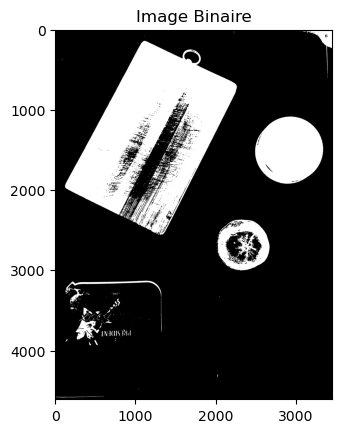

In [8]:
# binary thresholding
gaussian_image = cv2.GaussianBlur(pca_image, (11, 11), 0)
_, binary_image = cv2.threshold(gaussian_image, 100, 255, cv2.THRESH_BINARY_INV)

plt.imshow(binary_image, cmap="gray")
plt.title("Image Binaire")
plt.show()

## Utilisation de la Binarisation Adaptive

Après avoir constaté que la binarisation avec un seuil fixe ne donne pas les résultats souhaités, nous allons opter pour une approche de binarisation adaptive.

### Binarisation Adaptive

La binarisation adaptive ajuste dynamiquement le seuil en fonction des caractéristiques locales de l'image. Cette approche devrait mieux s'adapter aux variations d'intensité dans différentes parties de l'image, ce qui peut être crucial pour détecter des objets avec des nuances de couleurs et d'intensités variables.

### Résolution du Problème avec le Fraîdoux

La binarisation adaptive devrait améliorer la détection des objets, en particulier du "fraidoux", qui présente des couleurs claires similaires à l'arrière-plan. Cette approche offre une flexibilité accrue pour traiter des scénarios où la luminosité des objets peut varier significativement.

Nous allons maintenant appliquer la binarisation adaptive pour préparer notre image pour la détection de contours et l'analyse ultérieure des objets.


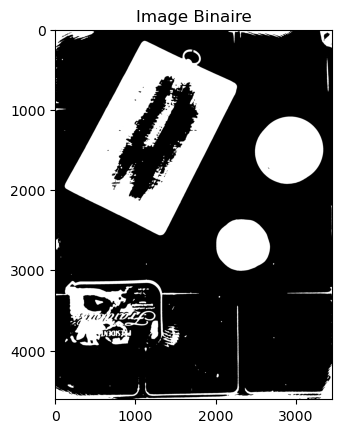

In [9]:
gaussian_image = cv2.GaussianBlur(pca_image, (35, 35), 0)
binary_image = cv2.adaptiveThreshold(
    gaussian_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 1001, 4
)

plt.imshow(binary_image, cmap="gray")
plt.title("Image Binaire")
plt.show()

## Prétraitement pour la Gestion des Faux Positifs

Après avoir opté pour la binarisation adaptive, nous avons constaté une amélioration dans la détection des pixels du "fraidoux". Cependant, un problème subsiste avec l'augmentation des faux positifs, c'est-à-dire la détection de pixels d'arrière-plan comme s'ils faisaient partie du premier plan.

### Élimination des Bruits avec une Bordure

Pour atténuer ce problème, nous allons introduire une étape de prétraitement en définissant une bordure autour de l'image binarisée. Cette bordure sera fixée à 0, éliminant ainsi certains bruits indésirables à la périphérie de l'image.

### Post-traitement avec une Opération d'Opening

Après avoir éliminé la bordure, nous envisagerons d'appliquer une opération d'ouverture (opening). Cette opération consiste à effectuer une érosion suivie d'une dilatation, ce qui peut contribuer à éliminer les faux positifs tout en préservant la forme générale des objets.

Ces étapes de prétraitement et de post-traitement visent à améliorer la qualité de la segmentation et à réduire les erreurs de classification.


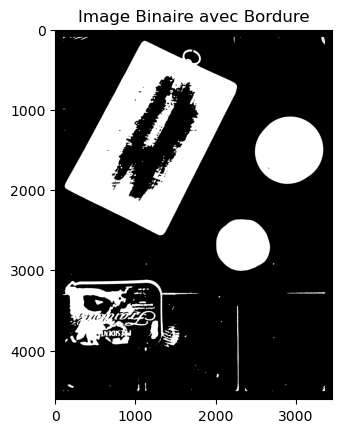

In [10]:
border = 100
black_border_image = binary_image.copy()
black_border_image[:, :border] = 0
black_border_image[:, -border:] = 0
black_border_image[:border, :] = 0
black_border_image[-border:, :] = 0

plt.imshow(black_border_image, cmap="gray")
plt.title("Image Binaire avec Bordure")
plt.show()

## Post-traitement avec une Opération d'Opening

Pour traiter les faux positifs détectés après la binarisation adaptive, nous allons appliquer une opération d'ouverture en utilisant un élément structurant de forme elliptique.

### Paramètres de l'Opération d'Opening

-   **Type d'Élément Structurant :** Elliptique
-   **Taille de l'Élément Structurant :** (35, 35)
-   **Nombre d'Iterations :** 1

### Objectif de l'Opération d'Opening

L'opération d'ouverture consiste à effectuer une érosion suivie d'une dilatation. En utilisant un élément structurant elliptique de taille (35, 35) et une seule itération, nous visons à éliminer les faux positifs tout en préservant la forme générale des objets.

Cela devrait contribuer à améliorer la précision de la segmentation et à minimiser les erreurs de classification dans l'image binarisée.

Nous allons maintenant appliquer cette opération d'ouverture pour obtenir une segmentation plus robuste de notre image.


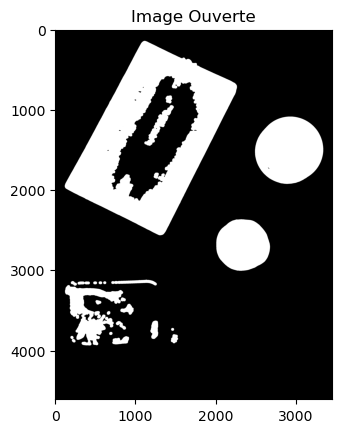

In [11]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (19, 19))
opened_image = cv2.morphologyEx(
    black_border_image, cv2.MORPH_OPEN, kernel, iterations=2
)

plt.imshow(opened_image, cmap="gray")
plt.title("Image Ouverte")
plt.show()

## Amélioration de la Segmentation avec une Opération de Fermeture

En complément de l'opération d'ouverture, nous allons appliquer une opération de fermeture pour améliorer davantage la qualité de la segmentation.

### Paramètres de l'Opération de Fermeture

-   **Type d'Élément Structurant :** Elliptique
-   **Taille de l'Élément Structurant :** (501, 501)
-   **Nombre d'Iterations :** 1

### Objectif de l'Opération de Fermeture

L'opération de fermeture consiste à effectuer une dilatation suivie d'une érosion. En utilisant un élément structurant elliptique de grande taille (501, 501) avec une seule itération, nous visons à éliminer les petites lacunes dans les objets détectés, créant ainsi une segmentation plus homogène.

Cela devrait contribuer à réduire davantage les faux positifs et à affiner la détection des contours des objets dans l'image.

Nous allons maintenant appliquer cette opération de fermeture pour finaliser notre segmentation améliorée.


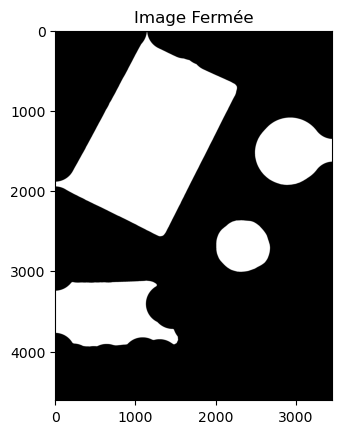

In [12]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (501, 501))
closed_image = cv2.morphologyEx(opened_image, cv2.MORPH_CLOSE, kernel, iterations=1)


plt.imshow(closed_image, cmap="gray")
plt.title("Image Fermée")
plt.show()

## Réinitialisation de la Bordure après les Opérations Morphologiques

Suite à l'application des opérations morphologiques (ouverture et fermeture) pour améliorer la segmentation, nous allons réinitialiser la bordure autour de l'image.

### Réinitialisation de la Bordure

Nous avions précédemment défini une bordure à zéro pour éliminer certains bruits à la périphérie de l'image. Cependant, avec les opérations morphologiques, nous pouvons réinitialiser cette bordure pour conserver une représentation complète de notre image tout en maintenant les améliorations apportées par les opérations morphologiques.

### Objectif

L'objectif de cette étape est d'avoir une image bien prétraitée avec des opérations morphologiques, prête pour la détection précise des contours et l'analyse ultérieure des objets.

Nous allons maintenant procéder à la réinitialisation de la bordure et examiner les résultats finaux de notre processus de segmentation améliorée.


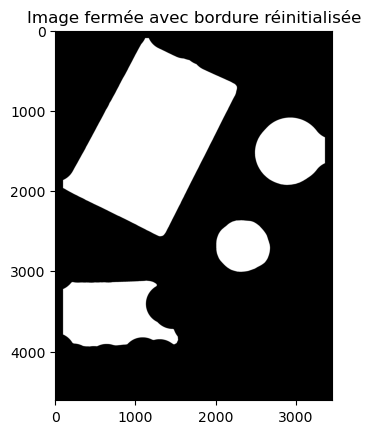

In [13]:
reset_border_image = closed_image.copy()
border = 100
reset_border_image[:border, :] = 0
reset_border_image[-border:, :] = 0
reset_border_image[:, :border] = 0
reset_border_image[:, -border:] = 0

plt.imshow(reset_border_image, cmap="gray")
plt.title("Image fermée avec bordure réinitialisée")
plt.show()

## Détection de Contours avec l'Opérateur de Sobel

Après avoir réalisé les opérations de prétraitement, notamment la binarisation adaptive et les opérations morphologiques, nous allons procéder à la détection de contours en utilisant l'opérateur de Sobel.

### Objectif de la Détection de Contours

L'opérateur de Sobel est un filtre utilisé pour mettre en évidence les contours dans une image. En appliquant cet opérateur à notre image prétraitée, nous pouvons obtenir une représentation des contours qui facilitera l'analyse des formes et des structures des objets.

### Application de l'Opérateur de Sobel

Nous allons appliquer l'opérateur de Sobel sur notre image prétraitée pour obtenir les contours. Le résultat sera une image mettant en évidence les variations d'intensité qui correspondent aux contours des objets détectés.

Nous allons maintenant procéder à cette étape cruciale de détection de contours pour notre analyse d'image.


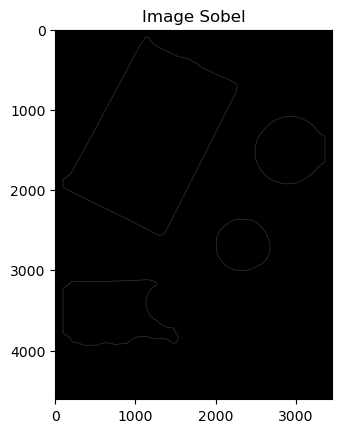

In [14]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

sobel_x_image = scipy.signal.convolve2d(reset_border_image, sobel_x, mode="same")
sobel_y_image = scipy.signal.convolve2d(reset_border_image, sobel_y, mode="same")

sobel_image = np.sqrt(sobel_x_image**2 + sobel_y_image**2)
sobel_image = (sobel_image / sobel_image.max() * 255).astype(np.uint8)

plt.imshow(sobel_image, cmap="gray")
plt.title("Image Sobel")
plt.show()

## Amélioration de la Visibilité des Contours avec le Gradient Morphologique

Suite à la détection des contours avec l'opérateur de Sobel, nous avons observé que les contours étaient très fins. Pour améliorer la visibilité et mieux mettre en évidence les contours détectés, nous allons appliquer une opération de gradient morphologique.

### Paramètres du Gradient Morphologique

-   **Type d'Élément Structurant :** Elliptique
-   **Taille de l'Élément Structurant :** (7, 7)

### Objectif du Gradient Morphologique

Le gradient morphologique est obtenu en soustrayant l'image érodée de l'image dilatée. En utilisant un élément structurant elliptique de taille (7, 7), nous cherchons à élargir les contours, améliorant ainsi leur visibilité.

### Application du Gradient Morphologique

Nous allons appliquer le gradient morphologique sur notre image de contours détectés pour obtenir une représentation plus claire et plus robuste des contours des objets.

Cette étape permettra de mieux visualiser les contours pour une analyse plus détaillée de la structure des objets dans notre image.


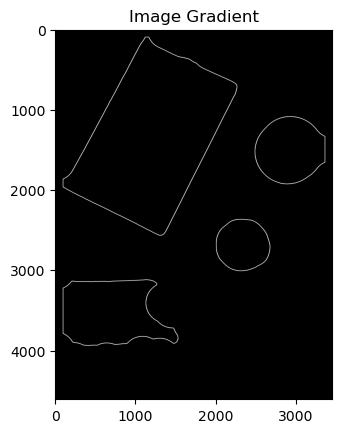

In [15]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
gradient_image = cv2.morphologyEx(sobel_image, cv2.MORPH_GRADIENT, kernel, iterations=1)

plt.imshow(gradient_image, cmap="gray")
plt.title("Image Gradient")
plt.show()

## Dessin des Contours sur l'Image d'Origine

Après avoir amélioré la visibilité des contours à l'aide du gradient morphologique, nous allons maintenant superposer ces contours sur l'image d'origine.

### Objectif du Dessin des Contours

En dessinant les contours détectés sur l'image d'origine, nous pouvons visualiser comment ces contours correspondent aux formes et aux structures des objets. Cela permettra une analyse plus complète de la détection des contours dans le contexte de l'image complète.

### Procédure de Dessin des Contours

Nous utiliserons les contours obtenus après le gradient morphologique et les superposerons sur l'image d'origine. Cela créera une représentation visuelle où les contours sont mis en évidence, facilitant l'interprétation des résultats de notre analyse d'image.

Nous allons maintenant procéder à cette étape finale pour obtenir une visualisation complète de la détection des contours dans notre image.


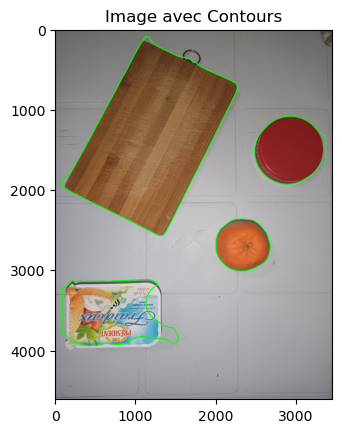

In [16]:
# Draw detected edges on original image
contours, hierarchy = cv2.findContours(
    gradient_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
image_with_contours = image.copy()
cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 11)

rgb_image = cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image)
plt.title("Image avec Contours")
plt.show()

## Calcul du Nombre de Pixels pour Chaque Objet

Après une détection satisfaisante des contours pour la planche, le bouchon et l'orange, nous allons maintenant procéder au calcul du nombre de pixels pour chaque objet dans l'image.

### Objectif du Calcul du Nombre de Pixels

En mesurant la superficie occupée par chaque objet en termes de nombre de pixels, nous pouvons quantifier leur taille relative. Cela fournit des informations quantitatives sur la distribution spatiale des objets dans l'image.

### Méthode de Calcul

Nous utiliserons les contours détectés pour chaque objet et compterons le nombre de pixels à l'intérieur de ces contours. Cette opération permettra de déterminer la taille de chaque objet en pixels.

Nous allons maintenant procéder au calcul du nombre de pixels pour chaque objet dans notre image.


In [17]:
objects = ["fraidoux", "orange", "bouchon", "planche"]
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    print(f"{objects[i]}: {area} pixels")

fraidoux: 886661.0 pixels
orange: 346742.0 pixels
bouchon: 575878.0 pixels
planche: 2882021.5 pixels


## Dessin des Boîtes Englobantes (Bounding Boxes)

Pour compléter notre analyse d'image, nous allons maintenant dessiner des boîtes englobantes autour de chaque objet détecté. Les boîtes englobantes fourniront une représentation rectangulaire de la position et de la taille de chaque objet dans l'image.

### Objectif des Boîtes Englobantes

Les boîtes englobantes permettent de délimiter visuellement chaque objet détecté, facilitant ainsi l'identification et la localisation précise de ces objets dans l'image. Cela apporte une dimension supplémentaire à notre analyse spatiale.

### Procédure de Dessin des Boîtes Englobantes

Nous utiliserons les contours et les informations sur les objets détectés pour déterminer les coordonnées des boîtes englobantes. Ces boîtes seront ensuite dessinées sur l'image d'origine pour visualiser la position et la taille de chaque objet.

### Analyse Visuelle des Résultats

La visualisation des boîtes englobantes permettra une interprétation plus détaillée des résultats de notre analyse d'image, en mettant en évidence la localisation spatiale des objets dans l'image.

Nous allons maintenant procéder au dessin des boîtes englobantes pour conclure notre analyse.


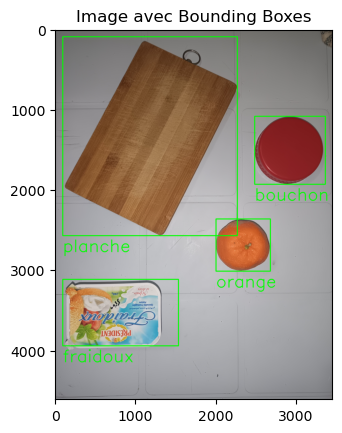

In [18]:
image_with_boxes = image.copy()

objects = ["fraidoux", "orange", "bouchon", "planche"]

for index, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 11)
    cv2.putText(
        image_with_boxes,
        objects[index],
        (x, y + h + 200),
        cv2.FONT_HERSHEY_SIMPLEX,
        7,
        (0, 255, 0),
        11,
    )

rgb_image = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

plt.imshow(rgb_image)
plt.title("Image avec Bounding Boxes")
plt.show()

## Conclusion

Dans le cadre de ce mini-projet d'analyse d'image, nous avons entrepris une série d'étapes visant à détecter et analyser des objets de différentes formes, tailles et couleurs dans une scène capturée par un appareil photo numérique. Voici un résumé des principales étapes et résultats obtenus :

### 1. Acquisition de l'Image

Nous avons utilisé un appareil photo numérique, en l'occurrence celui d'un téléphone Infinix Note 11 Pro, pour capturer une scène composée d'objets variés tels qu'une planche, un bouchon, une orange et du "fraidoux" (fromage).

### 2. Prétraitement de l'Image

-   Nous avons choisi une approche de binarisation adaptative pour mieux gérer les variations d'intensité.
-   Des opérations morphologiques (ouverture et fermeture) ont été appliquées pour traiter les faux positifs et améliorer la segmentation.

### 3. Détection des Contours

-   L'opérateur de Sobel a été utilisé pour détecter les contours dans l'image prétraitée.
-   Un gradient morphologique a été appliqué pour améliorer la visibilité des contours.

### 4. Dessin des Boîtes Englobantes

Des boîtes englobantes ont été dessinées autour de chaque objet détecté, offrant une représentation visuelle de leur position et taille.

### Résultats et Observations

-   Une détection parfaite a été réalisée pour la planche, le bouchon et l'orange.
-   La détection du "fraidoux" a été améliorée, bien qu'il présente des défis en raison de sa couleur similaire à l'arrière-plan.

### Axes d'Amélioration

Ce mini-projet a permis de mettre en pratique des techniques fondamentales d'analyse d'image, de la capture initiale à la détection des contours et à la quantification des objets. Bien que des résultats satisfaisants aient été obtenus, il est important de noter les défis liés à la similitude de couleur dans la détection d'objets spécifiques.

Des axes d'amélioration pourraient inclure l'exploration de méthodes plus avancées pour la détection d'objets similaires au "fraidoux" ainsi que l'optimisation des paramètres des opérations morphologiques pour une meilleure adaptation à des scènes complexes.

Ce projet a offert une expérience pratique précieuse dans le domaine de l'analyse d'image, soulignant à la fois les succès obtenus et les opportunités d'amélioration continue.
